## Introdução à Ciência de Dados - Universidade de São Paulo

# Questionário 3 - Teoria da Decisão Bayesiana

##### Prof. Francisco Rodrigues - Aluno: Gean Gobo da Cruz - N° USP: 13661979


### Pacotes

In [51]:
from sklearn.preprocessing import LabelEncoder # Usamos para o pré-processamento dos dados
from sklearn.model_selection import train_test_split # Separar treino e teste
from sklearn.preprocessing import StandardScaler # Ajustando a escala dos dados
from sklearn.naive_bayes import GaussianNB # Modelo Naive Bayes
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay # Métricas de avaliação
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # Modelo QDA
from sklearn.neighbors import KernelDensity # Estimador de densidade
from sklearn.model_selection import GridSearchCV # Busca em grade para hiperparâmetros
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

### Classificador não-paramétrico

In [34]:
class KDEClassifier:
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models_ = {}
        self.priors_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.models_[c] = KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(X_c)
            self.priors_[c] = len(X_c) / len(X)
        return self

    def predict_proba(self, X):
        log_likelihoods = np.array([model.score_samples(X) for _, model in self.models_.items()]).T
        log_posteriors = log_likelihoods + np.log(list(self.priors_.values()))
        # Normaliza para que as probabilidades somem 1 (opcional, mas bom para consistência)
        from scipy.special import logsumexp
        log_probs = log_posteriors - logsumexp(log_posteriors, axis=1)[:, np.newaxis]
        return np.exp(log_probs)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

    # Métodos necessários para compatibilidade com GridSearchCV
    def get_params(self, deep=True):
        return {'bandwidth': self.bandwidth, 'kernel': self.kernel}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

### Datasets

In [28]:
df_vertebral = pd.read_csv('../data/vertebralcolumn-2C.csv')
df_red = pd.read_csv('../data/winequality-red.csv')


### 1. Considerando a base de dados vertebralcolumn-2C.csv, encontre o melhorclassificador dentre os métodos classificador Bayesiano, classificador Bayesino não-paramétrico e Naive Bayes.


In [27]:
df_vertebral.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


Separar Variáveis Independentes (Features) e Variável Alvo (Target)

In [5]:
# 'X' conterá as features (todas as colunas, exceto a última)
X = df_vertebral.iloc[:, :-1]

# 'y' conterá a variável alvo (a última coluna, 'class')
y = df_vertebral.iloc[:, -1]

print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())

Features (X):
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0         63.027817    22.552586              39.609117     40.475232   
1         39.056951    10.060991              25.015378     28.995960   
2         68.832021    22.218482              50.092194     46.613539   
3         69.297008    24.652878              44.311238     44.644130   
4         49.712859     9.652075              28.317406     40.060784   

   pelvic_radius  degree_spondylolisthesis  
0      98.672917                 -0.254400  
1     114.405425                  4.564259  
2     105.985135                 -3.530317  
3     101.868495                 11.211523  
4     108.168725                  7.918501  

Target (y):
0    Abnormal
1    Abnormal
2    Abnormal
3    Abnormal
4    Abnormal
Name: class, dtype: object


Label Encoding - Condificando a variável alvo, pois ml não trabalha com texto e sim 0 ou 1. 

In [10]:
# Aplicando a codificacão na variável y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [11]:
# O LabelEncoder geralmente ordena alfabeticamente, então 'Abnormal' se torna 0 e 'Normal' se torna 1.
print(f"Classes originais: {le.classes_}")
print(f"Primeiros 5 valores de y antes da codificação: {y.head().values}")
print(f"Primeiros 5 valores de y após a codificação: {y_encoded[:5]}")

Classes originais: ['Abnormal' 'Normal']
Primeiros 5 valores de y antes da codificação: ['Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal']
Primeiros 5 valores de y após a codificação: [0 0 0 0 0]


Dividir os Dados em Conjuntos de Treino e Teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treino: 248 amostras
Tamanho do conjunto de teste: 62 amostras


Feature Scaling - Padronização dos dados: Temos que tomar cuidado com a sensibildiade a escalas muito diferentes de features. 

In [ ]:
# Cria o scaler
scaler = StandardScaler()

# Ajusta e transforma os dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Apenas transforma os dados de teste (usando o ajuste feito com os dados de treino)
X_test_scaled = scaler.transform(X_test)

# Convertendo de volta para DataFrame para visualização (opcional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Dados de treino padronizados (primeiras 5 linhas):")
print(X_train_scaled.head())

Dados de treino padronizados (primeiras 5 linhas):
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0          0.751299     0.358793               0.265541      0.704144   
1          0.730159    -0.797490               0.565371      1.514558   
2          1.656737     0.512492               2.035762      1.754627   
3          1.098472     3.089342               0.000090     -0.828224   
4          0.668654    -0.019898              -0.021432      0.872397   

   pelvic_radius  degree_spondylolisthesis  
0       0.212944                  1.215560  
1      -1.383068                  0.009995  
2      -1.251299                 -0.596465  
3      -0.492699                  1.042556  
4       0.137725                  0.140048  


Modelo 1: Naive Bayes (Gaussiano)

In [18]:
# 1. Instanciar e treinar o modelo
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

# 2. Fazer previsões no conjunto de teste
y_pred_gnb = gnb.predict(X_test_scaled)

Modelo 2: Classificador Bayesiano "Puro" (Análise Discriminante Quadrática - QDA)

In [19]:
# 1. Instanciar e treinar o modelo
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# 2. Fazer previsões no conjunto de teste
y_pred_qda = qda.predict(X_test_scaled)

/Users/geangobo/Projetos/Introduction-to-Data-Science-USP/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/geangobo/Projetos/Introduction-to-Data-Science-USP/.venv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Modelo 3: Classificador Bayesiano Não-Paramétrico (com Kernel Density Estimation)

In [ ]:
# 1. Instanciar e treinar o modelo não-paramétrico
kde_clf = KDEClassifier(bandwidth=0.5) # O bandwidth é um hiperparâmetro que pode ser ajustado
kde_clf.fit(X_train_scaled, y_train)

# 2. Fazer previsões no conjunto de teste
y_pred_kde = kde_clf.predict(X_test_scaled)

Avaliacão e comparação dos modelos da questão 1. 

In [22]:
target_names = ['Abnormal', 'Normal']

#  Resultados para Naive Bayes
print("\n--- Classificador Naive Bayes (Gaussiano) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_gnb):.4f}")
print(classification_report(y_test, y_pred_gnb, target_names=target_names))

# Resultados para QDA
print("\n--- Classificador Bayesiano (QDA) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_qda):.4f}")
print(classification_report(y_test, y_pred_qda, target_names=target_names))

# Resultados para Não-Paramétrico (KDE)
print("\n--- Classificador Bayesiano Não-Paramétrico (KDE) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_kde):.4f}")
print(classification_report(y_test, y_pred_kde, target_names=target_names))


--- Classificador Naive Bayes (Gaussiano) ---
Acurácia: 0.8065
              precision    recall  f1-score   support

    Abnormal       0.97      0.74      0.84        42
      Normal       0.63      0.95      0.76        20

    accuracy                           0.81        62
   macro avg       0.80      0.84      0.80        62
weighted avg       0.86      0.81      0.81        62


--- Classificador Bayesiano (QDA) ---
Acurácia: 0.8548
              precision    recall  f1-score   support

    Abnormal       1.00      0.79      0.88        42
      Normal       0.69      1.00      0.82        20

    accuracy                           0.85        62
   macro avg       0.84      0.89      0.85        62
weighted avg       0.90      0.85      0.86        62


--- Classificador Bayesiano Não-Paramétrico (KDE) ---
Acurácia: 0.8387
              precision    recall  f1-score   support

    Abnormal       0.92      0.83      0.88        42
      Normal       0.71      0.85      0.77  

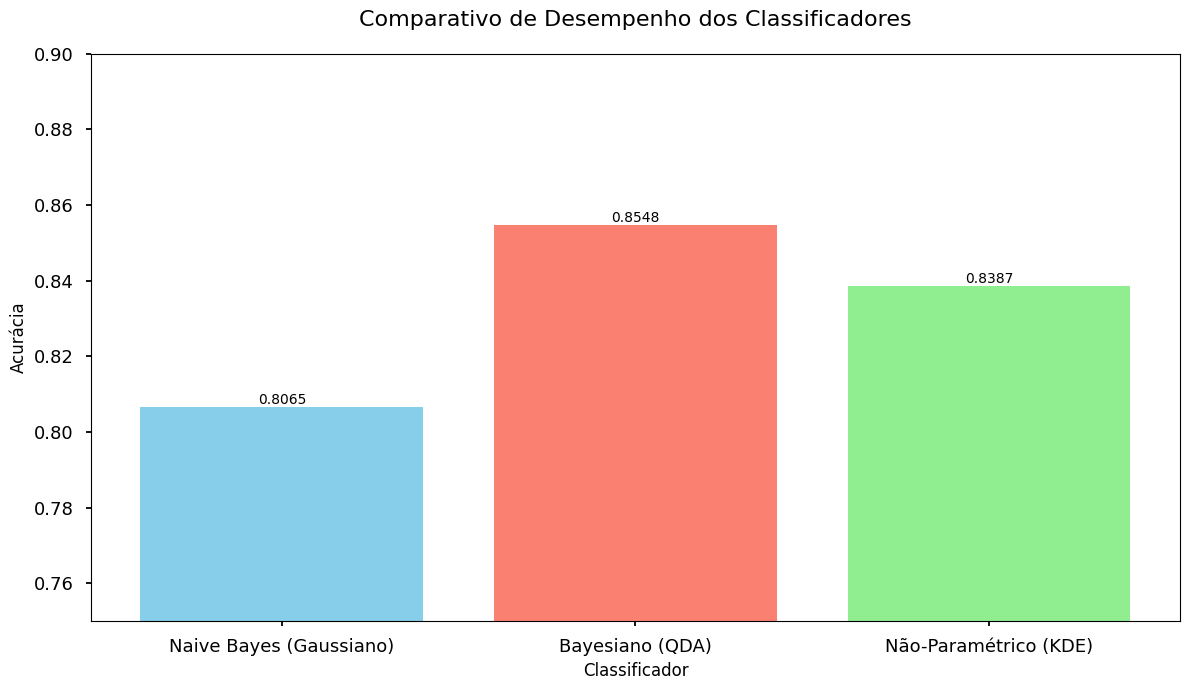

In [23]:
# 1. Calcular as acurácias
acc_gnb = accuracy_score(y_test, y_pred_gnb)
acc_qda = accuracy_score(y_test, y_pred_qda)
acc_kde = accuracy_score(y_test, y_pred_kde)

# 2. Preparar os dados para o gráfico
nomes_classificadores = ['Naive Bayes (Gaussiano)', 'Bayesiano (QDA)', 'Não-Paramétrico (KDE)']
acuracias = [acc_gnb, acc_qda, acc_kde]

# 3. Criar o gráfico
plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(12, 7))

bars = plt.bar(nomes_classificadores, acuracias, color=['skyblue', 'salmon', 'lightgreen'])

# Adicionar o valor exato em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # va: vertical alignment

# Customizar o gráfico
plt.title('Comparativo de Desempenho dos Classificadores', fontsize=16, pad=20)
plt.ylabel('Acurácia', fontsize=12)
plt.xlabel('Classificador', fontsize=12)
plt.ylim(0.75, 0.9) # Ajusta o limite do eixo Y para destacar a diferença
plt.tight_layout()
plt.show()

### 2. Considerando a base de dados “winequality-red”, encontre o valor do hiperparâmetro h que oferece a maior acurácia no Bayesino não-paramétrico.


In [29]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Dado que já fizemos um processo semelhante de preparação dos dados: Separar feature/alvo, dividir em treino/teste, além de padronizar, vou ir direto ao ponto. 

In [31]:
# Separando features X e alvo y - já que a coluna 'quality' é o alvo
X = df_red.drop('quality', axis=1)
y = df_red['quality']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Executando a Busca pelo Melhor h
- Vamos precisar do nosso classificador não-paramétrico, ele foi definido em uma classe no início do notebook devido o sklearn não ter suporte. (Não esqueça de rodar a célula)

In [36]:
param_grid = {
    'bandwidth': np.logspace(-1, 1, 20)
}

grid_search = GridSearchCV(
    KDEClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("Iniciando a busca pelo melhor hiperparâmetro 'h'...")
grid_search.fit(X_train_scaled, y_train)


print("\nBusca finalizada!")
print(f"O melhor valor para 'h' (bandwidth) encontrado foi: {grid_search.best_params_['bandwidth']:.4f}")
print(f"A acurácia média com este valor (via validação cruzada) foi: {grid_search.best_score_:.4f}")

Iniciando a busca pelo melhor hiperparâmetro 'h'...

Busca finalizada!
O melhor valor para 'h' (bandwidth) encontrado foi: 0.8859
A acurácia média com este valor (via validação cruzada) foi: 0.6270


In [37]:
# O grid_search já está treinado com o melhor 'h' usando todos os dados de treino
y_pred_final = grid_search.predict(X_test_scaled)

acuracia_final = accuracy_score(y_test, y_pred_final)

print(f"\nA acurácia do melhor modelo no conjunto de teste final foi: {acuracia_final:.4f}")


A acurácia do melhor modelo no conjunto de teste final foi: 0.6188


### 3. Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e oclassificador Bayesiano não-paramétrico (escolha um valor para h).

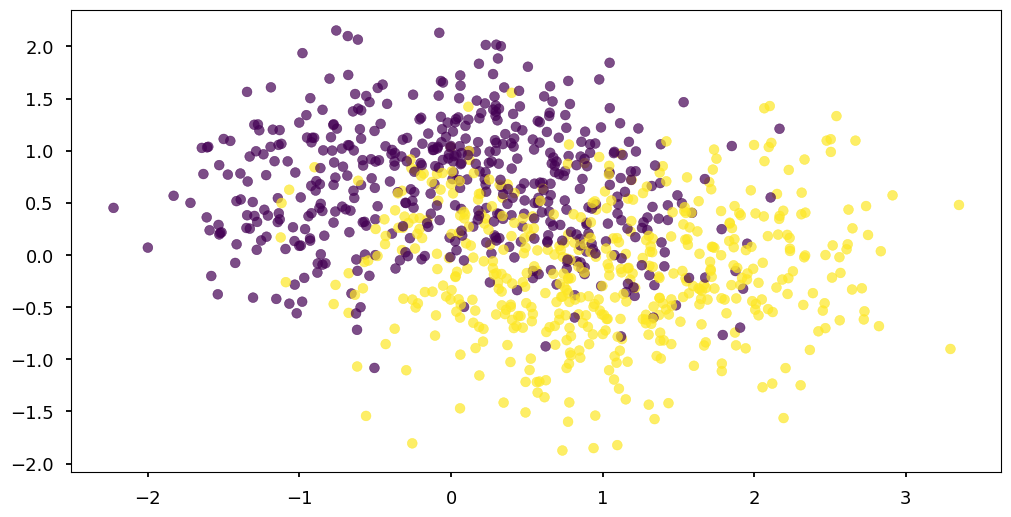

In [44]:
plt.figure(figsize=(12,6))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.5)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# --- Modelo 1: Naive Bayes (Gaussiano) ---
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_pred_gnb = gnb.predict(X_test_scaled)

In [48]:
# --- Modelo 2: Classificador Bayesiano Paramétrico (QDA) ---
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)

KDEClassifier definimos no início

In [49]:
# --- Modelo 3: Classificador Bayesiano Não-Paramétrico (KDE) --- 
kde_clf = KDEClassifier(bandwidth=0.5)
kde_clf.fit(X_train_scaled, y_train)
y_pred_kde = kde_clf.predict(X_test_scaled)

Resultados

In [50]:
print("="*30)
print("      Resultados Numéricos")
print("="*30)

# Resultados para Naive Bayes
print("\n--- Naive Bayes (Gaussiano) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_gnb):.4f}")

# Resultados para QDA
print("\n--- Classificador Bayesiano (QDA) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_qda):.4f}")

# Resultados para Não-Paramétrico (KDE)
print("\n--- Classificador Não-Paramétrico (KDE) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_kde):.4f}")

      Resultados Numéricos

--- Naive Bayes (Gaussiano) ---
Acurácia: 0.8467

--- Classificador Bayesiano (QDA) ---
Acurácia: 0.8467

--- Classificador Não-Paramétrico (KDE) ---
Acurácia: 0.8333


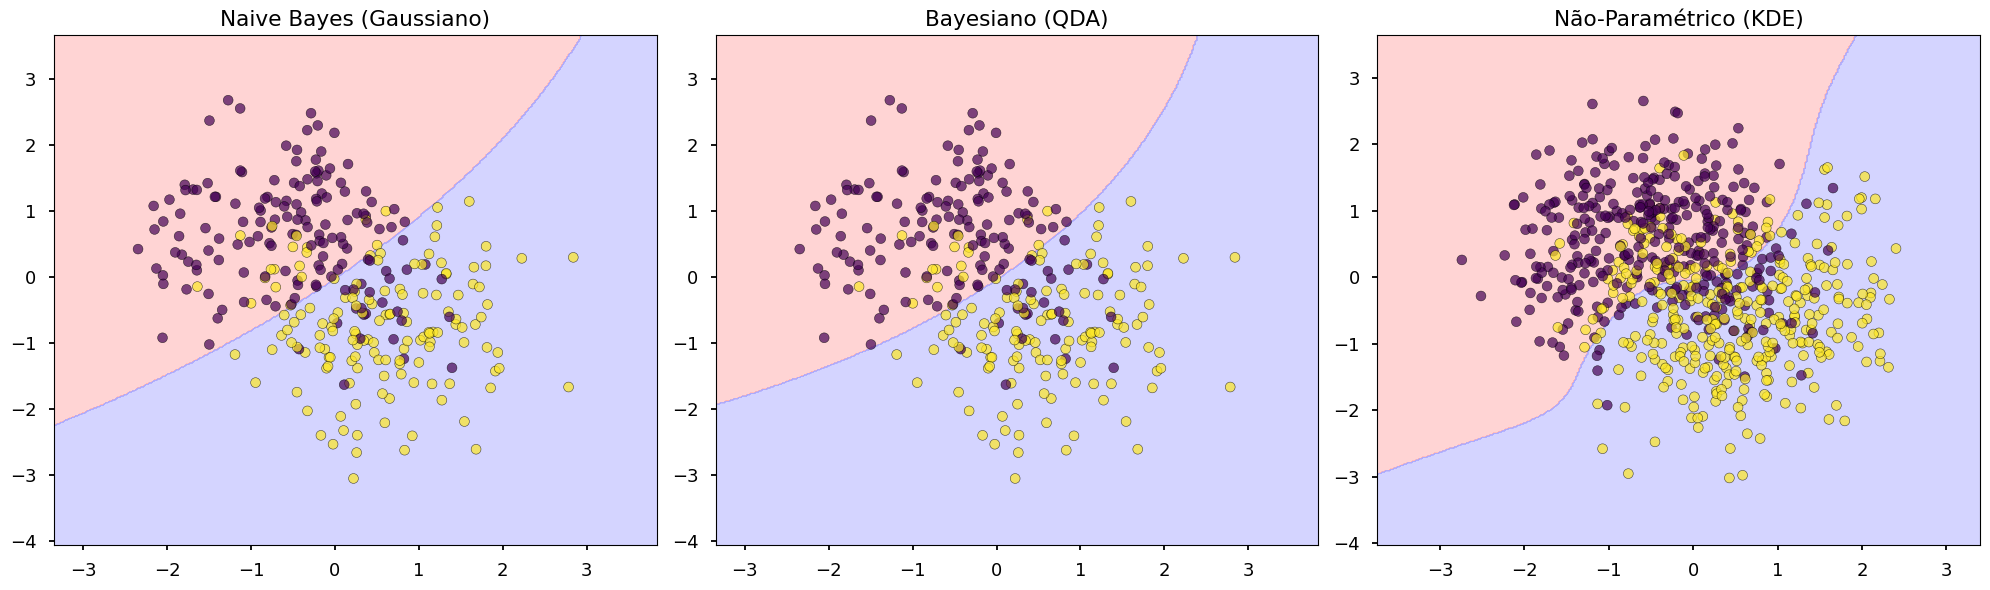

In [52]:
# Função para plotar a fronteira de decisão
def plot_decision_boundary(clf, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.7, edgecolor='k')
    ax.set_title(title)

# Criar a figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plotar a fronteira para cada classificador
plot_decision_boundary(gnb, X_test_scaled, y_test, axes[0], 'Naive Bayes (Gaussiano)')
plot_decision_boundary(qda, X_test_scaled, y_test, axes[1], 'Bayesiano (QDA)')
plot_decision_boundary(kde_clf, X_train_scaled, y_train, axes[2], 'Não-Paramétrico (KDE)') # Usamos treino para KDE para melhor visualização da fronteira aprendida

plt.tight_layout()
plt.show()